# W266 Final Project Code
# Amazon Product Review Aspect-Based Sentiment
## Jennifer Mahle and Joanna Wang (Sections 3 and 1, respectively) 

#### Introduction
For our final project, we built a classification system for Amazon product reviews. The system categorizes product reviews into various classes of what the review focuses on, then determines whether the review is positive or negative for a given product trait (ie durability, quality, etc). As a user, star ratings alone might not give enough information about the product, so reading the reviews still is the best way to determine if the product fits the user’s needs. The challenge is, sometimes there can be hundreds of reviews for a product and users cannot spend time reading all of them.  So we want to provide this classification system to reduce the review reading process and help the users to find what they need. 


### Exploratory Data Analysis

In this section, we load, clean, and explore the data. We are using Amazon product reviews for electronics from the website https://nijianmo.github.io/amazon/index.html

In [1]:
#Import packages 
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import os
import sys

In [2]:
#!pip3 install --user keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [ ]:
#DON'T NEED TO RUN THIS PART FOR NOW. RUN THE NEXT CELL TO LOAD DATA
#####################################################################
dataset = "Electronics_5.json"

if os.path.isfile(dataset):
    df = pd.read_json("Electronics_5.json", lines=True)
else:
    url = r"http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz"
    df = pd.read_json(url, compression='gzip', lines=True)

display(df.tail(10))
df.shape
print(df.info())
df_mini = df[(df.asin == "B01HJCN1EI") | (df.asin == "B01HJH42KU") | 
                            (df.asin == "B01HJH40WU") | (df.asin == "B01HJF704M") | 
                           (df.asin == "B01HJCN5GC") | (df.asin == "B01HJCN5TO") |
                           (df.asin == "B01HJDNL60") | (df.asin == "B01HJDR9DQ") |
                           (df.asin == "B01HJFFHTC") | (df.asin == "B01HJCN1EI")]
df_mini.shape
df_mini.to_csv('/home/wangjia/datasci-w266-finalProject/df_mini.csv')
######################################################################

In [3]:
df = pd.read_csv("df_mini.csv") 
display(df.tail(10))
df.shape
print(df.info())

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
141,6739580,5,NaN,True,"07 25, 2017",A1OOVLE2KZ6KGA,B01HJCN1EI,NaN,Puddzee,These are my favorite charging cords for a few...,Worth the price.,1500940800,NaN
142,6739581,1,NaN,True,"04 4, 2017",A77K1B31UAQ29,B01HJCN1EI,NaN,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING,1491264000,NaN
143,6739582,3,NaN,True,"07 8, 2017",A2SVXUVUAWUDK2,B01HJH42KU,NaN,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...,1499472000,NaN
144,6739583,2,NaN,True,"05 21, 2017",A12E1JGKV0ETAB,B01HJH42KU,NaN,John Adams,I liked the length and the product at first bu...,Lost ability to connect.,1495324800,NaN
145,6739584,3,NaN,True,"06 26, 2017",A1HKXEX8BEQC2E,B01HJH40WU,NaN,Dasha stephens,not holding up over time :(,not holding up over time :(,1498435200,NaN
146,6739585,4,NaN,True,"03 21, 2017",A33MAQA919J2V8,B01HJH40WU,NaN,Kurt Wurm,"These seem like quality USB cables, time will ...",Four Stars,1490054400,NaN
147,6739586,4,NaN,True,"01 9, 2017",A1AKHSCPD1BHM4,B01HJH40WU,NaN,C.L Momof3,"Works great, love the longer cord. As with any...",Nice long cord,1483920000,NaN
148,6739587,5,2.0,True,"12 1, 2016",A2HUZO7MQAY5I2,B01HJH40WU,NaN,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,1480550400,NaN
149,6739588,5,2.0,True,"11 29, 2016",AJJ7VX2L91X2W,B01HJH40WU,NaN,Faith,Works well.,Five Stars,1480377600,NaN
150,6739589,5,NaN,True,"03 31, 2017",A1FGCIRPRNZWD5,B01HJF704M,NaN,Brando,I have it plugged into a usb extension on my g...,Works well enough..,1490918400,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 13 columns):
Unnamed: 0        151 non-null int64
overall           151 non-null int64
vote              20 non-null float64
verified          151 non-null bool
reviewTime        151 non-null object
reviewerID        151 non-null object
asin              151 non-null object
style             15 non-null object
reviewerName      151 non-null object
reviewText        151 non-null object
summary           151 non-null object
unixReviewTime    151 non-null int64
image             5 non-null object
dtypes: bool(1), float64(1), int64(3), object(8)
memory usage: 14.4+ KB
None


In [4]:
#Remove NA review rows
df = df.dropna(subset=['reviewText'])
#Checking one of the reviews
print(df["reviewText"].iloc[100])

This works great, i needed a longer cable (this is 10') and stronger connection between the plug & wire.  This looks like it is stronger.


In [5]:
# Downloading stopwords
nltk.download('stopwords')

#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

#function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wangjia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in df.reviewText:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (df['reviewText'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(df['reviewText'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [7]:
#adding a column of CleanedText which displays the data after pre-processing of the review
df['CleanedText']=final_string  
df['CleanedText']=df['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',df.shape)
df.head()

Shape of final (151, 14)


,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,CleanedText
0,6099679,5,NaN,True,"10 10, 2016",ATGTQKPUR7XIO,B01HJCN5GC,NaN,Arthur,Great buy!,Five Stars,1476057600,NaN,great buy
1,6099680,5,NaN,True,"09 8, 2016",A15VV7NPTST593,B01HJCN5GC,NaN,Randy T.,Works very well and we have lots (& lots) of e...,Extend your reach with ease,1473292800,NaN,work well lot lot extra extens abl pass devic ...
2,6099681,5,NaN,True,"03 15, 2017",AIM3MWK3Y7XOR,B01HJCN5GC,NaN,Kindle Customer,This cable is very flexible. Just what I wanted.,Flexible cable,1489536000,NaN,cabl flexibl want
3,6099682,5,NaN,True,"02 16, 2017",A5W6EI03IKOLB,B01HJCN5GC,NaN,P.Davidson,"These are the best charging cables, and if oth...",Best cables,1487203200,NaN,best charg cabl famili member didnt take would...
4,6099683,4,NaN,True,"02 14, 2017",A3QZTMHQ1XZ8PM,B01HJCN5GC,NaN,glittergirl,I bought this in rose gold or light pink and i...,super cute cord,1487030400,NaN,bought rose gold light pink clear bubblegum br...


In [8]:
#After processing the sample review looks like this
print(df["CleanedText"].iloc[100])

work great need longer cabl stronger connect plug wire look like stronger


In [9]:
#Sorting data according to asin in ascending order
sorted_data=df.sort_values('asin', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"reviewerID","reviewerName","reviewText","summary"}, keep='first', inplace=False)

#Removed not verified rows
final = final[final.verified != False]

#Drop NA 
final = final.dropna(subset=['reviewText'])
print(final.shape)

(128, 14)


### Text Encoding using Universal Sentence Encoder

In the subsequent code cells, we load the Universal Sentence Encoder (USE), break the data into training and testing data, and apply the USE to the data. 

In [10]:
!pip3 uninstall tensorflow-gpu
!pip3 uninstall tensorflow

Found existing installation: tensorflow-gpu 2.1.0
Uninstalling tensorflow-gpu-2.1.0:
  Would remove:
    /home/wangjia/anaconda3/bin/estimator_ckpt_converter
    /home/wangjia/anaconda3/bin/saved_model_cli
    /home/wangjia/anaconda3/bin/tensorboard
    /home/wangjia/anaconda3/bin/tf_upgrade_v2
    /home/wangjia/anaconda3/bin/tflite_convert
    /home/wangjia/anaconda3/bin/toco
    /home/wangjia/anaconda3/bin/toco_from_protos
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow/*
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/*
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_gpu-2.1.0.dist-info/*
  Would not remove (might be manually added):
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/app/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/audio/__init__.py
    /ho

    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/compat/v1/saved_model/signature_def_utils/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/compat/v1/saved_model/tag_constants/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/compat/v1/saved_model/utils/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/compat/v1/sets/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/compat/v1/signal/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/compat/v1/sparse/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/compat/v1/spectral/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v1/compat/v1/strings/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/

    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/saved_model/python/saved_model/reader.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/seq2seq/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/seq2seq/ops/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/seq2seq/ops/gen_beam_search_ops.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/seq2seq/python/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/seq2seq/python/ops/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/seq2seq/python/ops/_beam_search_ops.so
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/seq2seq/python/ops/attention_wrapper.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/seq2seq/python/ops/basi

Proceed (y/n)? ^C
ERROR: Operation cancelled by user
Found existing installation: tensorflow 1.15.0
Uninstalling tensorflow-1.15.0:
  Would remove:
    /home/wangjia/anaconda3/bin/estimator_ckpt_converter
    /home/wangjia/anaconda3/bin/freeze_graph
    /home/wangjia/anaconda3/bin/saved_model_cli
    /home/wangjia/anaconda3/bin/tensorboard
    /home/wangjia/anaconda3/bin/tf_upgrade_v2
    /home/wangjia/anaconda3/bin/tflite_convert
    /home/wangjia/anaconda3/bin/toco
    /home/wangjia/anaconda3/bin/toco_from_protos
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow-1.15.0.dist-info/*
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow/*
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/*
  Would not remove (might be manually added):
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v2/__init__.py
    /home/wangjia/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v2/audio/__init__.py
    /home/wang

Proceed (y/n)? ^C
ERROR: Operation cancelled by user


In [10]:
# Remove ## from lines starting with ! and run them the first time to install necessary packages 

##%%capture
# Install the Tensorflow 2.0.0 version.
!pip3 install --user tensorflow==2.0.0
# Install TF-Hub.
!pip3 install --user tensorflow-hub
!pip3 install --user seaborn


In [11]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [12]:
#create embeddings on the training data 
logging.set_verbosity(logging.ERROR)
message_embeddings = embed(final.CleanedText)

In [13]:
print("Training X Shape", final.shape)

Training X Shape (128, 14)


In [14]:
final.head()

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,CleanedText
96,6099775,5,NaN,True,"09 6, 2016",A2A871CAU2PP3F,B01HJCN1EI,NaN,Joyce Mirowski,I enjoy reading on the kindle the cable i s lo...,very nice cable,1473120000,NaN,enjoy read kindl cabl long enough keep charg d...
141,6739580,5,NaN,True,"07 25, 2017",A1OOVLE2KZ6KGA,B01HJCN1EI,NaN,Puddzee,These are my favorite charging cords for a few...,Worth the price.,1500940800,NaN,favorit charg cord reason length mean reach an...
101,6099780,5,6.0,True,"08 14, 2016",A2AWUJAT7Z6L68,B01HJCN1EI,NaN,Luanne Serrato,"<a data-hook=""product-link-linked"" class=""a-li...",Great Buy!,1471132800,NaN,kindl usb cabl nylon usb cabl deego high speed...
100,6099779,5,NaN,True,"08 22, 2016",A1LYZQDDYM3VKW,B01HJCN1EI,NaN,kfb,"This works great, i needed a longer cable (thi...","This works great, i needed a longer cable (thi...",1471824000,NaN,work great need longer cabl stronger connect p...
99,6099778,5,NaN,True,"08 25, 2016",A3DDSH3IG02ESZ,B01HJCN1EI,NaN,Volunteer,I actually bought this to charge my Kindle Fir...,Works Great,1472083200,NaN,actual bought charg kindl fire work great thin...


In [29]:
message_embeddings.shape

TensorShape([128, 512])

In [44]:
message_embeddings = np.array([np.reshape(embed, (len(embed), 1)) for embed in message_embeddings])
message_embeddings.shape

(128, 512, 1)

In [16]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

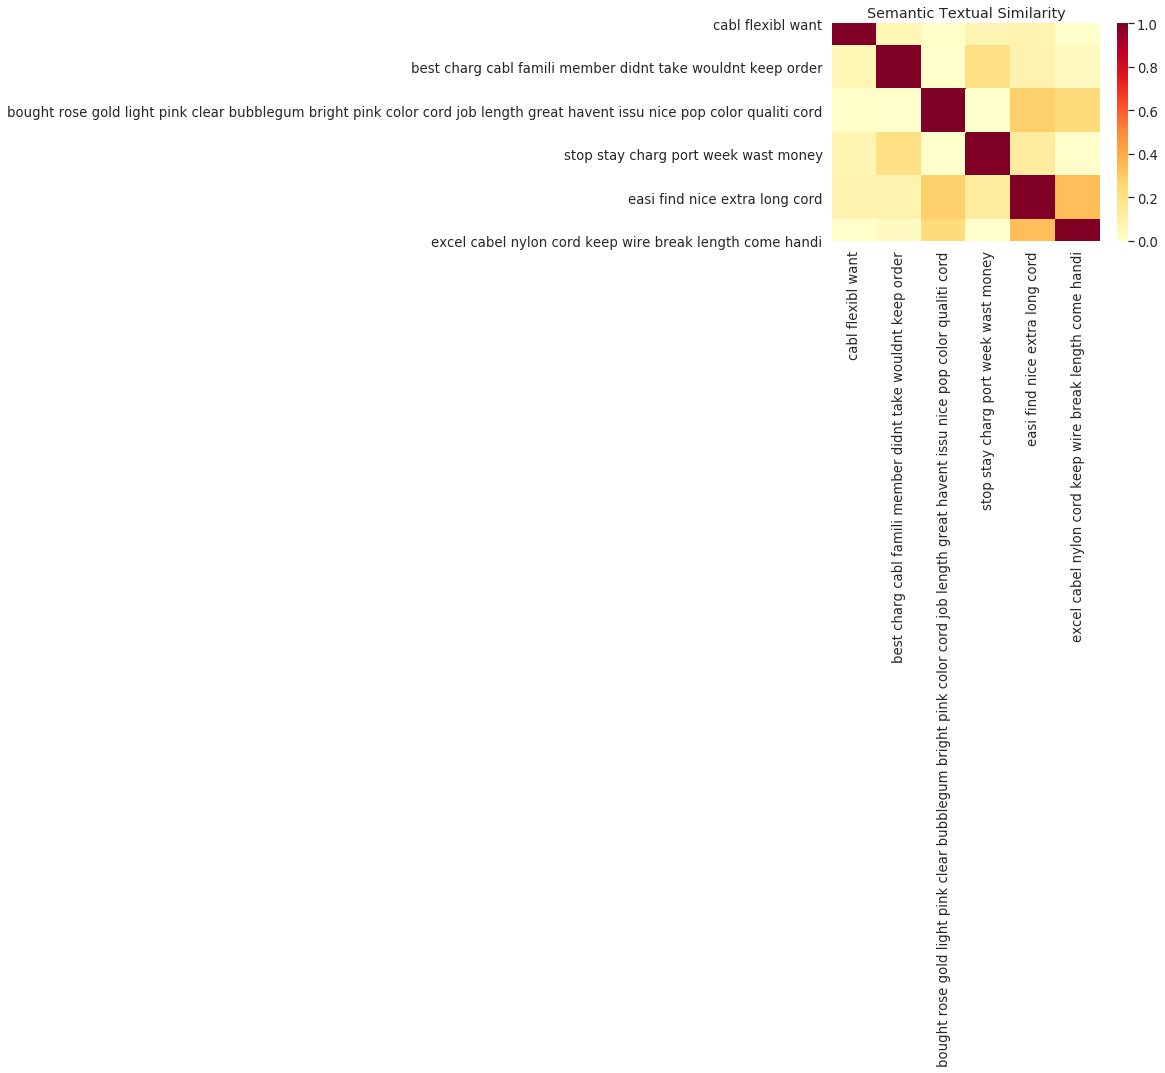

In [25]:
reviews_messages = final.CleanedText

run_and_plot(reviews_messages[24:30])

## Model creation

In [33]:
labels=final.overall


In [34]:
from tqdm import tqdm

labels_one_hot = []

with tqdm(total=len(labels)) as pbar:
  for label in labels:
    if label == 0:
      labels_one_hot.append([1., 0.])
    else:
      labels_one_hot.append([0., 1.])
      
    pbar.update(1)

100%|██████████| 128/128 [00:00<00:00, 195083.91it/s]


In [35]:
labels_one_hot = np.array(labels_one_hot)


In [60]:
import pickle

embeddings_file = "message_embeddings.pickle".format(len(message_embeddings))
labels_file = "labels.pickle".format(len(labels))

pickle.dump(message_embeddings, open(embeddings_file, 'wb'))
pickle.dump(labels, open(labels_file, 'wb'))

In [61]:
import pickle

message_embeddings = pickle.load(open('message_embeddings.pickle', 'rb'))
labels = pickle.load(open('labels.pickle', 'rb'))

In [62]:
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(message_embeddings, labels, test_size=.3)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((89, 512, 1), (89, 2), (39, 512, 1), (39, 2))

In [63]:
vector_size = 512
batch_size = 500
no_epochs = 10

In [67]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard

model = Sequential()

model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same',
                 input_shape=(vector_size, 1)))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=3))

model.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.3)))

model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 512, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 512, 32)           3104      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 512, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 170, 32)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1024)              2232320   
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)              

In [65]:
model.fit(np.array(x_train), np.array(y_train), batch_size=batch_size, epochs=no_epochs,
         validation_data=(np.array(x_test), np.array(y_test)), callbacks=[tensorboard, EarlyStopping(min_delta=0.0001, patience=3)])

Train on 89 samples, validate on 39 samples
Epoch 1/10
89/89 [==============================] - 6s 66ms/step - loss: 0.2502 - accuracy: 0.9663 - val_loss: 0.1419 - val_accuracy: 1.0000
Epoch 2/10
89/89 [==============================] - 8s 93ms/step - loss: 0.1688 - accuracy: 1.0000 - val_loss: 0.1039 - val_accuracy: 1.0000
Epoch 3/10
89/89 [==============================] - 4s 47ms/step - loss: 0.1255 - accuracy: 1.0000 - val_loss: 0.0764 - val_accuracy: 1.0000
Epoch 4/10
89/89 [==============================] - 4s 47ms/step - loss: 0.0870 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 1.0000
Epoch 5/10
89/89 [==============================] - 4s 45ms/step - loss: 0.0631 - accuracy: 1.0000 - val_loss: 0.0427 - val_accuracy: 1.0000
Epoch 6/10
89/89 [==============================] - 4s 46ms/step - loss: 0.0511 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 1.0000
Epoch 7/10
89/89 [==============================] - 4s 48ms/step - loss: 0.0394 - accuracy: 1.0000 - val_loss:

In [68]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), 
    	signature="default", as_dict=True)["default"]

In [69]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding,
	output_shape=(embed_size,))(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(category_counts, activation='softmax')(dense)
model2 = Model(inputs=[input_text], outputs=pred)
model2.compile(loss='categorical_crossentropy', 
	optimizer='adam', metrics=['accuracy'])

NameError: name 'layers' is not defined

In [54]:
model.metrics_names

['loss', 'accuracy']

In [55]:
model.evaluate(x=x_test, y=y_test, batch_size=500, verbose=1)


13/13 [==============================] - 0s 16ms/step


[0.24636206030845642, 1.0]

## Stanford POS Tagger to Find Product Attributes

We use the Stanford POS tagger to find the most common nouns used in product reviews for each product ID (ASIN). Then we use the most common nouns as product attributes. 

In [ ]:
#!python -m pip install --upgrade pip
#!pip install torch
#!pip install stanfordnlp

In [ ]:
# need to install java (unless you already have it installed) 
# and update the path to where ever it is stored on your computer
import os
java_path = "C:/Program Files/Java/jre1.8.0_241/bin/java.exe"
os.environ['JAVAHOME'] = java_path

# need to follow instructions to install Stanford POS tagger here: 
# https://phitchuria.wordpress.com/2018/09/29/python-nltk-using-stanford-pos-tagger-in-nltk-on-windows/
from nltk.tag import StanfordPOSTagger
from nltk.corpus import stopwords
stanford_dir = "C:\Stanford\stanford-postagger-2018-10-16"
modelfile = stanford_dir+"\models\english-bidirectional-distsim.tagger"
jarfile=stanford_dir+"\stanford-postagger.jar"

tagger=StanfordPOSTagger(model_filename=modelfile, path_to_jar=jarfile)

In [ ]:
freq_dist={}
for i in range(1,len(x_train)): 
#for i in range(1,10): 
    tagged_POS = tagger.tag(x_train.reviewText[i].split())
    for word,tag in tagged_POS:
        if tag == 'NN' or tag == 'NNS':
            if word in freq_dist:
                freq_dist[word] += 1
            else:
                freq_dist[word] = 1


In [ ]:
import operator
sorted_freq_dist=sorted(freq_dist.items(),key=operator.itemgetter(1))
# change into the dictionary since it is easier to approach
dict_sorted_freq_dist=dict(sorted_freq_dist)

print(dict_sorted_freq_dist)

In [ ]:
print(freq_dist[0])